# Make Yolo dataset

Takes a coco annotation file and transforms its labels into the yolo format.

Destination folders:

`labels/trainTraffic`

and

`labels/trainTraffic`

The folders contain one `.txt` file each with the image's name. File contents is:

`[category_id x y height width]`


In [ ]:
# Class names for YOLO .yaml file
yolo_names = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck', 'fire hydrant', 'stop sign', 'cat', 'dog', 'traffic_light_green',
                'traffic_light_red', 'traffic_light_na']

In [1]:
%matplotlib inline
from pycocotools.coco import COCO

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import random
import json
import csv
from shutil import copyfile
import os

pylab.rcParams['figure.figsize'] = (15.0, 20.0)

In [9]:
# Helper functions
def box_coco_to_yolo(bbox_coco, img):
    """
    Transforms a bounding box from COCO style to nromalized YOLO style.
    COCO: x, y, h, w
    YOLO: x_center, y_center, width, height

    Args:
    bbox_coco   -- List of bounding box coordinates in coco format: [x,y,w,h] with x,y at the top centre.
    img         -- Dictionary with image meta data.

    Returns:
    bbox_yolo   -- List of bbox coordinates in yolo format.
    """


    bbox_yolo = []
    bbox_yolo.append((bbox_coco[0] + 0.5 * bbox_coco[2])/img['width'])
    bbox_yolo.append((bbox_coco[1] + 0.5 * bbox_coco[3])/img['height'])
    bbox_yolo.append(bbox_coco[2]/img['width'])
    bbox_yolo.append(bbox_coco[3]/img['height'])

    return bbox_yolo


In [42]:
# def make_yolo_labels(dataset_name):
dataset_name = 'train'


# Set category_id mapping
# To accomodate our 15 classes, the category_ids are remapped before writing them to the labels for yolo.
# TODO: Delete traffic_light (10) since this will be refined into 92 etc.
classes = {'1': 'person','2': 'bicycle', '3': 'car', '4': 'motorcycle', '6': 'bus', '7': 'train', '8': 'truck', '10': 'traffic light',
 '11': 'fire hydrant', '13': 'stop sign', '17': 'cat', '18': 'dog', '92':'traffic_light_green', '93': 'traffic_light_red', '94': 'traffic_light_na'}

# Traffic_light has been replaced by the three new categories traffic_light_green (92), traffic_light_red (93), and traffic_light_na (94)
coco_to_yolo = {'1':'1', '2':'2', '3':'3', '4':'4', '6':'5', '7':'6', '8':'7', '11': '8', '13':'9', '17':'10', '18':'11', '92':'12', '93':'13', '94':'14',
'10':'14'} #TODO: Remove coco 10 once the new labels are available

classes_yolo = {'1':'person', '2':'bicycle', '3':'car', '4':'motorcycle', '5':'bus', '6':'train', '7':'truck', '8':'fire hydrant', '9':'stop sign', '10':'cat', '11':'dog', '12':'traffic_light_green', '13':'traffic_light_red', '14':'traffic_light_na', }

# Load coco dataset
dataDir='..'
dataType=dataset_name+'Traffic'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize COCO api for instance annotations
coco=COCO(annFile)

# Load COCO categories and supercategories
imgIds = coco.getImgIds()

print('Number of images: ' + str(len(imgIds)))

# Read annotation file
imgIds = imgIds[0:100]
# One file with filename = image_id containg all annotations
for imgId in imgIds:
    filename = (str(imgId)+'.txt').zfill(16) # Filenames have to be 12 characters long
    categoryId = []
    boxX = []
    boxY = []
    boxH = []
    boxW = []

    annIds = coco.getAnnIds(imgId)
    anns = coco.loadAnns(annIds)
    img = coco.loadImgs(imgId)

    # For each annotation:
    for ann in anns:
        categoryId.append(coco_to_yolo[str(ann['category_id'])])
        
        # TODO: Add bbox transformation. Arg: ann['bbox']
        bbox_yolo = box_coco_to_yolo(ann['bbox'], img[0])
        boxX.append(bbox_yolo[0])
        boxY.append(bbox_yolo[1])
        boxH.append(bbox_yolo[2])
        boxW.append(bbox_yolo[3])

    # Write file
    file_path = '../labels/' + dataset_name + 'Traffic/'
    
    rows = zip(categoryId, boxX, boxY, boxH, boxW)
    
    with open(file_path+filename, "w") as f:
        writer = csv.writer(f, delimiter=" ")
        for row in rows:
            writer.writerow(row)

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
Number of images: 9224


## Yolo annotation visualization
Loads a yolo label file and visualizes the annotations.

In [37]:
def show_annotations(dataset_name, image_number):
    # Get all file names
    file_path = '../labels/' + dataset_name
    image_names = os.listdir(file_path)

    # Pick a filename
    image_name = image_names[image_number]

    # Load annotation labels
    labels = []
    with open(file_path + '/' + image_name) as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            labels.append(row)

    # Load image
    I = io.imread('%s/images/%s/%s'%('..',dataset_name,image_name.split('.')[0]+'.jpg'))
    #x, y, _ = I.shape()
    print(I.shape)
    fig, ax = plt.subplots()

    # Colours for boxes
    colours = {1: 'red', 3: 'blue', 10: 'green'}

    for label in labels:
        # Draw boxes
        name = classes_yolo[label[0]]
        # Transform coordinates so that boxes are plotted correctly
        w = float(label[3]) * I.shape[1]
        h = float(label[4]) * I.shape[0]
        x = (float(label[1]) - 0.5 * float(label[3])) * I.shape[1]
        y = (float(label[2]) - 0.5 * float(label[4])) * I.shape[0]


        plt.text(x+1, y-5, name,fontdict={'fontsize':18.0, 'fontweight':'medium','color': 'white', 'backgroundcolor':'red'})
        bb = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(bb)
        
    ax.imshow(I)
    ax.axis('off')
    plt.show()

(333, 500, 3)


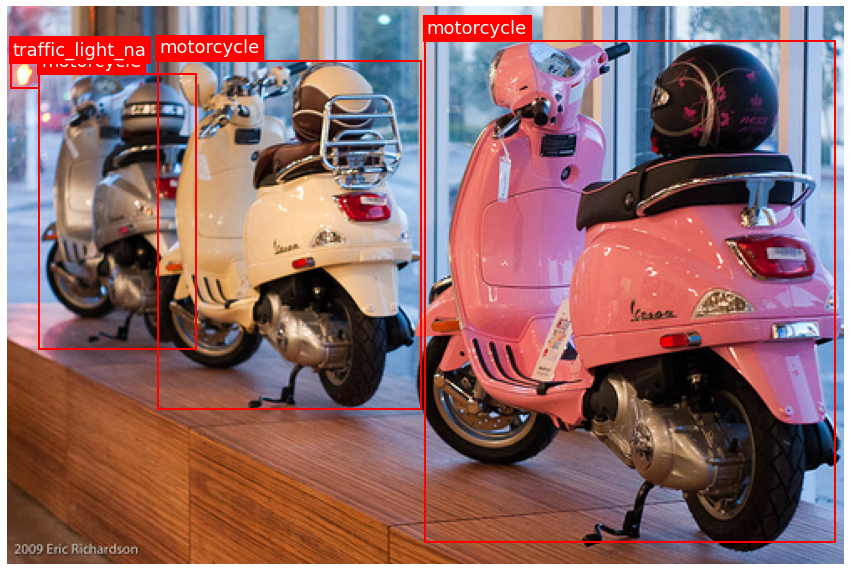

In [41]:
# Get filenames of all files in the folder
show_annotations('trainTraffic', 50)